#### Investigating the MODEL-006b / Approach-3 
- For weight stability over training loop
- for weight change between folds
- for logist & feature layer behaviour on unseen classes

In [1]:
import os 
from datetime import date, datetime
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader, DaLiAcReader, UTDReader
from src.datasets.dataset import PAMAP2Dataset, DaLiAcDataset, UTDDataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.utils.delta import compute_delta, setup_delta_tracking
# from src.running import train_step1, eval_step1

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model, bias=False)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

In [3]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model, bias=False)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

        del self.DenseL.weight
        self.DenseL.weight = nn.Parameter(torch.randn(d_model, in_ft), requires_grad=False)


    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
def train_step1(dataloader, optimizer, loss_module, device, class_names, prev_list, rmae_delta_dict, phase='train', l2_reg=False, loss_alpha=0.7):
    global model
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    # compute layer deltas after epoch.
    rmae_delta, prev_list = compute_delta(model, prev_list, rmae_delta_dict)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics, rmae_delta, prev_list

In [6]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

In [7]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
elif dt == 'DaLiAc':
    dataReader = DaLiAcReader('./data/DaLiAc_Dataset/')
elif dt == 'UTD':
    dataReader = UTDReader('./data/UTD-MHAD-Inertial/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
dataReader.data.shape

(124,)

In [10]:
# import PAMAP2 attributes
if dt == 'PAMAP2':   
    fpath = './data/PAMAP2_Dataset/PAMAP2_attributes.json'
elif dt == 'DaLiAc':
    fpath = './data/DaLiAc_Dataset/DaLiAc_attributes.json'
elif dt == 'UTD':
    fpath = './data/UTD-MHAD-Inertial/UTD_attributes.json'

activity_dict, attribute_dict, attr_mat = load_attribute(fpath)
_, attr_size = attr_mat.shape

In [11]:
# Load semantic feature space 
st = config['sem-space']
if dt == 'PAMAP2':
    if st == 'glove50-v1':
        fpath = './data/PAMAP2_Dataset/glove_features.npy'
    elif st == 'glove50-v2':
        fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
    elif st == 'video-V1':
        fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
    elif st == 'word2vec-v1':
        fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
    elif st == 'word2vec-v2':
        fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'
    elif st == 'attr':
        fpath = './data/PAMAP2_Dataset/attribute_ft.npy'
elif dt == 'DaLiAc':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/DaLiAc_Dataset/attribute_ft.npy'
elif dt == 'UTD':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/UTD-MHAD-Inertial/attribute_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [12]:
# run 5-fold running
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
elif dt == 'DaLiAc':
    fold_classes = [['sitting', 'vacuuming', 'descending stairs'], ['lying', 'sweeping', 'treadmill running'], ['standing', 'walking', 'cycling'], ['washing dishes', 'ascending stairs', 'rope jumping']]
elif dt == 'UTD':
    fold_classes = [['swipe left', 'cross arms', 'draw triangle', 'arm curl', 'jogging in place', 'pick up then throw'], ['swipe right', 'basketball shoot', 'bowling', 'tennis serve', 'walking in place', 'squat'], ['wave', 'draw x', 'boxing', 'two hand push', 'sit to stand'], ['clap', 'draw circle clockwise', 'baseball swing', 'knock', 'stand to sit'], ['throw', 'draw circle counter clockwise', 'tennis swing', 'catch', 'lunge']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [13]:
if config['dataset'] == 'PAMAP2':
    dts = PAMAP2Dataset
elif config['dataset'] == 'DaLiAc':
    dts = DaLiAcDataset
elif config['dataset'] == 'UTD':
    dts = UTDDataset

In [14]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 51])


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


seen: 100%|██████████| 130/130 [00:03<00:00, 36.38batch/s, loss=1.19]


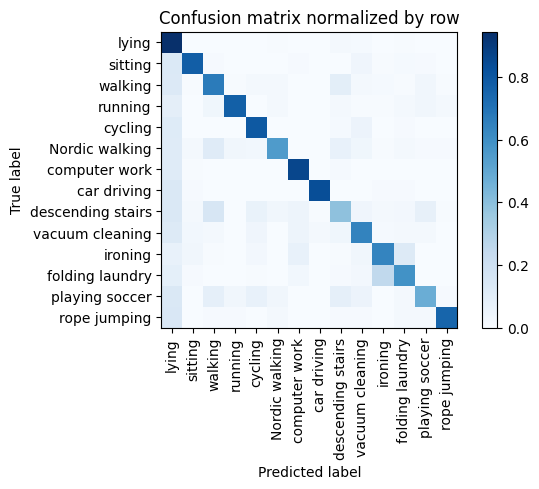

Training Epoch:  10%|█         | 1/10 [00:37<05:37, 37.53s/it]

Overall accuracy: 0.712



seen: 100%|██████████| 130/130 [00:01<00:00, 75.89batch/s, loss=0.87]


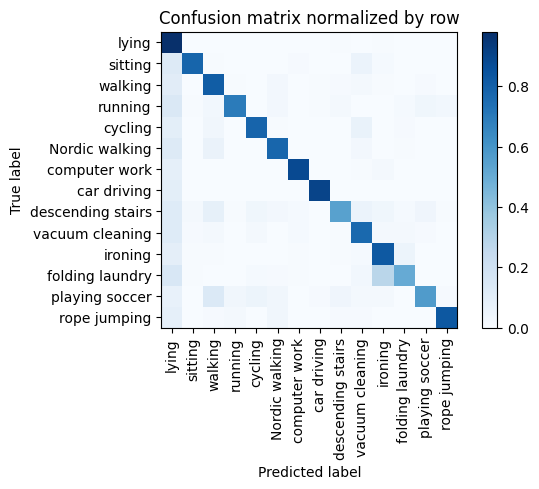

Training Epoch:  20%|██        | 2/10 [00:51<03:07, 23.43s/it]

Overall accuracy: 0.790



seen: 100%|██████████| 130/130 [00:01<00:00, 101.09batch/s, loss=0.592]


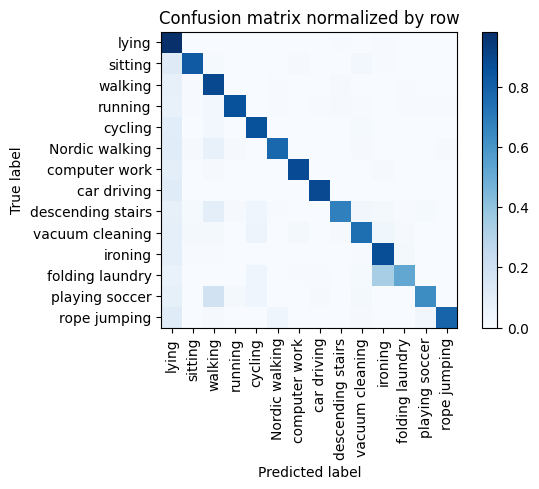

Training Epoch:  30%|███       | 3/10 [01:01<02:03, 17.58s/it]

Overall accuracy: 0.825



seen: 100%|██████████| 130/130 [00:01<00:00, 90.81batch/s, loss=0.581]


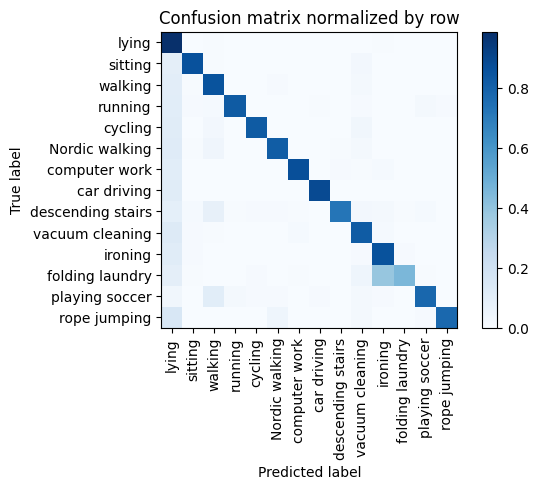

Training Epoch:  40%|████      | 4/10 [01:12<01:28, 14.73s/it]

Overall accuracy: 0.830



seen: 100%|██████████| 130/130 [00:01<00:00, 82.80batch/s, loss=0.554]


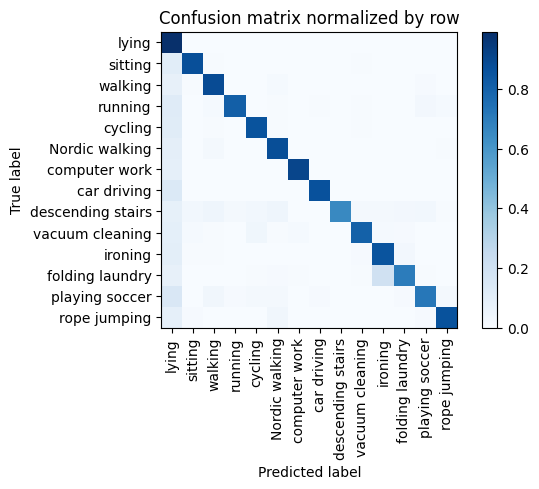

Training Epoch:  50%|█████     | 5/10 [01:23<01:07, 13.40s/it]

Overall accuracy: 0.855



seen: 100%|██████████| 130/130 [00:02<00:00, 50.92batch/s, loss=0.692]


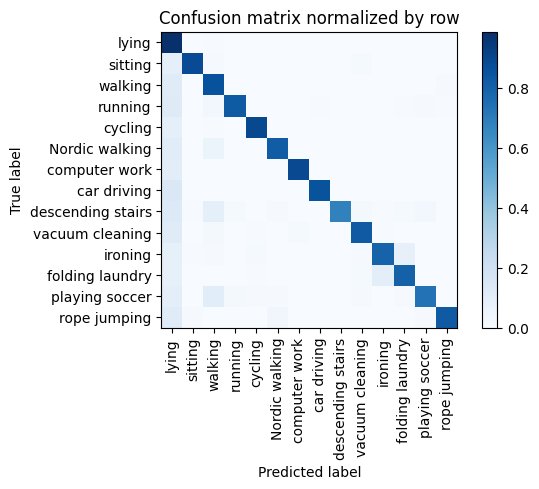

Training Epoch:  60%|██████    | 6/10 [01:36<00:53, 13.39s/it]

Overall accuracy: 0.849



seen: 100%|██████████| 130/130 [00:01<00:00, 84.69batch/s, loss=0.689]


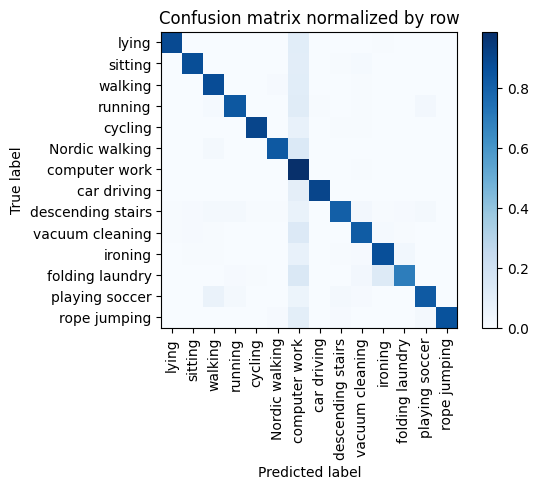

Training Epoch:  70%|███████   | 7/10 [01:48<00:38, 12.85s/it]

Overall accuracy: 0.871



seen: 100%|██████████| 130/130 [00:01<00:00, 98.93batch/s, loss=0.514]


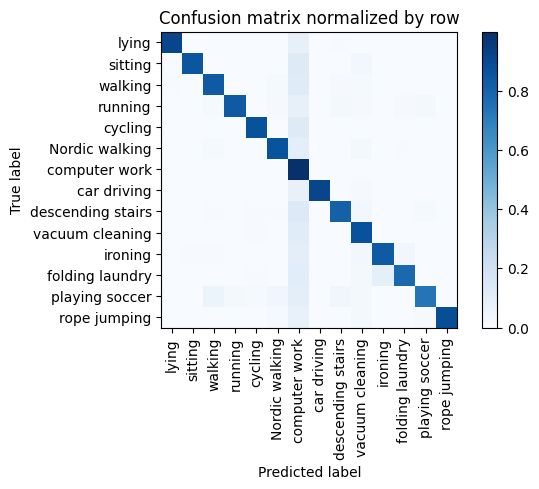

Training Epoch:  80%|████████  | 8/10 [02:00<00:25, 12.52s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 130/130 [00:01<00:00, 96.30batch/s, loss=0.446]


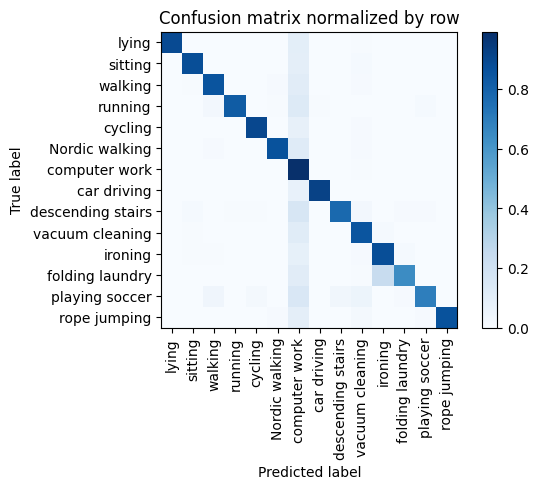

Training Epoch:  90%|█████████ | 9/10 [02:09<00:11, 11.71s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 130/130 [00:01<00:00, 115.44batch/s, loss=0.259]


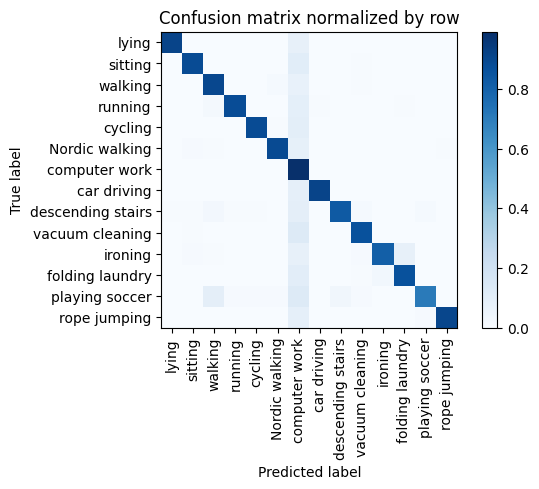

Overall accuracy: 0.888



unseen: 100%|██████████| 175/175 [00:01<00:00, 105.77batch/s, loss=4.67]


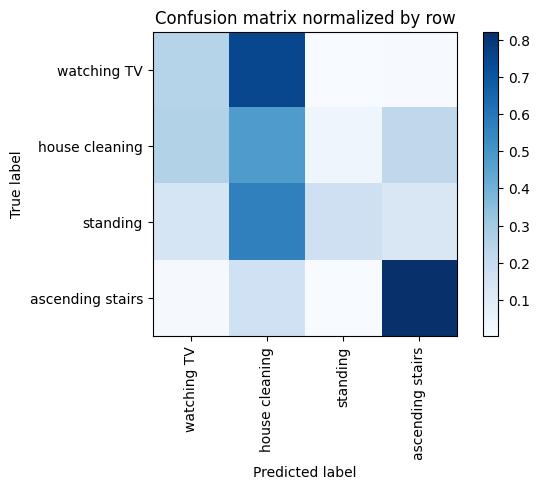

Overall accuracy: 0.410

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.816      0.173      0.285      0.330       1850|	 house cleaning: 0.567,	watching TV: 0.136,	
  house cleaning       0.323      0.481      0.387      0.328       1839|	 watching TV: 0.257,	ascending stairs: 0.225,	
ascending stairs       0.579      0.822      0.679      0.193       1081|	 house cleaning: 0.167,	watching TV: 0.008,	
     watching TV       0.218      0.247      0.232      0.148        830|	 house cleaning: 0.746,	ascending stairs: 0.006,	

----------------------------------------------------------------------------------------------------
     avg / total       0.520      0.410      0.387        1.0       5600|	      

{'total_accuracy': 0.41035714285714286, 'precision': 0.4842185027342938, 'recall': 0.4307609085581148, 'f1': 0.3958335830864675}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', '

seen: 100%|██████████| 131/131 [00:01<00:00, 96.47batch/s, loss=1.39] 


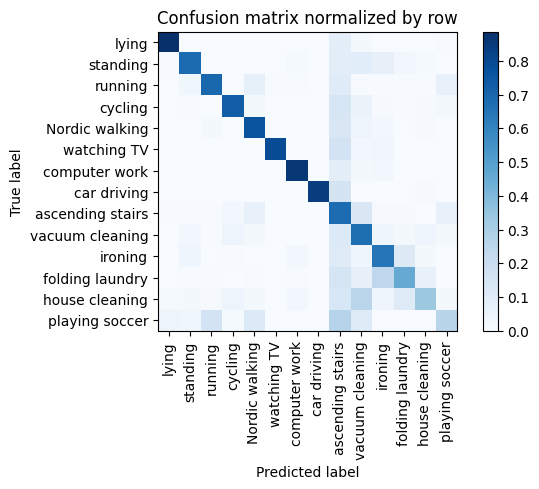

Training Epoch:  10%|█         | 1/10 [00:08<01:19,  8.83s/it]

Overall accuracy: 0.690



seen: 100%|██████████| 131/131 [00:01<00:00, 100.46batch/s, loss=1.18]


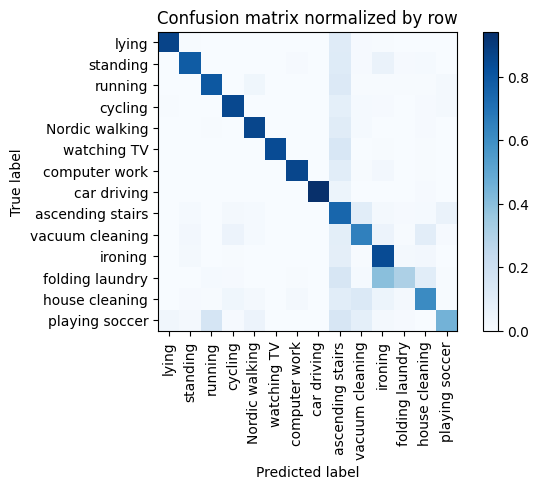

Training Epoch:  20%|██        | 2/10 [00:17<01:09,  8.69s/it]

Overall accuracy: 0.767



seen: 100%|██████████| 131/131 [00:01<00:00, 94.04batch/s, loss=0.761] 


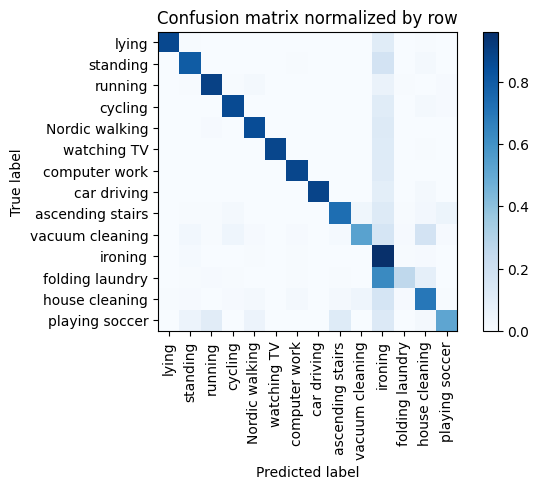

Training Epoch:  30%|███       | 3/10 [00:26<01:00,  8.70s/it]

Overall accuracy: 0.785



seen: 100%|██████████| 131/131 [00:01<00:00, 107.29batch/s, loss=0.627]


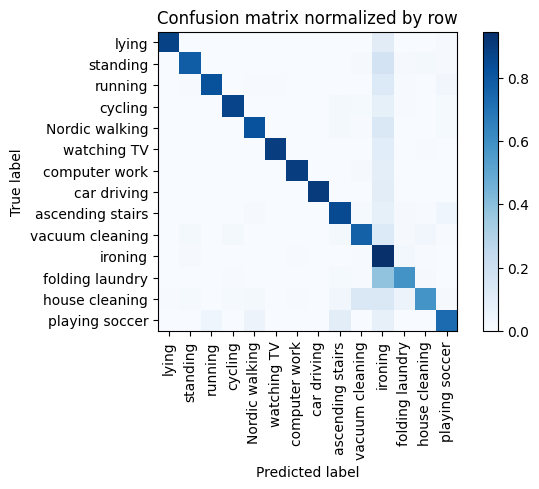

Training Epoch:  40%|████      | 4/10 [00:34<00:52,  8.74s/it]

Overall accuracy: 0.818



seen: 100%|██████████| 131/131 [00:01<00:00, 108.09batch/s, loss=0.458]


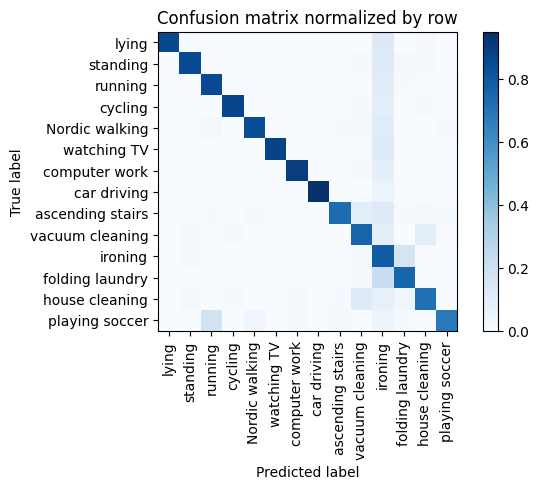

Training Epoch:  50%|█████     | 5/10 [00:43<00:43,  8.80s/it]

Overall accuracy: 0.823



seen: 100%|██████████| 131/131 [00:01<00:00, 111.68batch/s, loss=0.506]


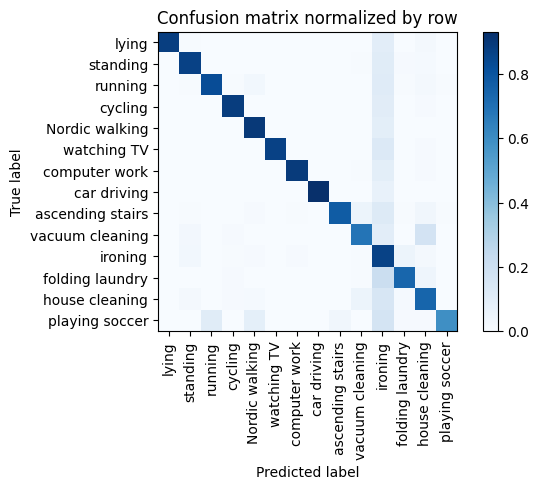

Training Epoch:  60%|██████    | 6/10 [00:52<00:34,  8.69s/it]

Overall accuracy: 0.832



seen: 100%|██████████| 131/131 [00:03<00:00, 33.96batch/s, loss=0.31]


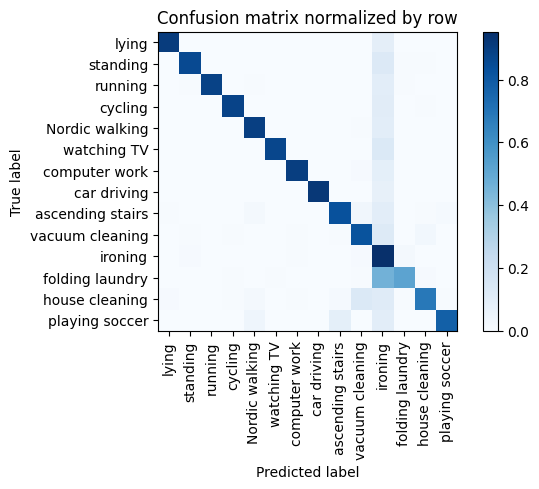

Training Epoch:  70%|███████   | 7/10 [01:09<00:34, 11.47s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 131/131 [00:02<00:00, 63.22batch/s, loss=0.592]


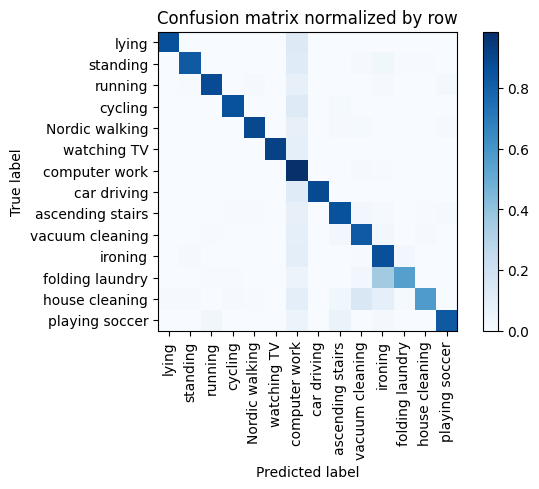

Training Epoch:  80%|████████  | 8/10 [01:25<00:25, 12.88s/it]

Overall accuracy: 0.838



seen: 100%|██████████| 131/131 [00:02<00:00, 55.77batch/s, loss=0.374]


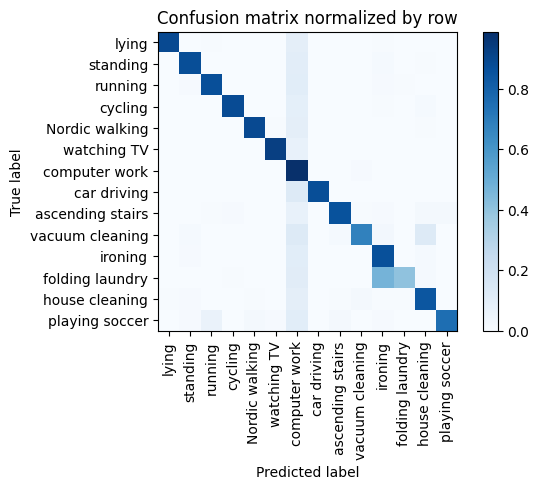

Training Epoch:  90%|█████████ | 9/10 [01:39<00:13, 13.39s/it]

Overall accuracy: 0.849



seen: 100%|██████████| 131/131 [00:02<00:00, 55.65batch/s, loss=0.438]


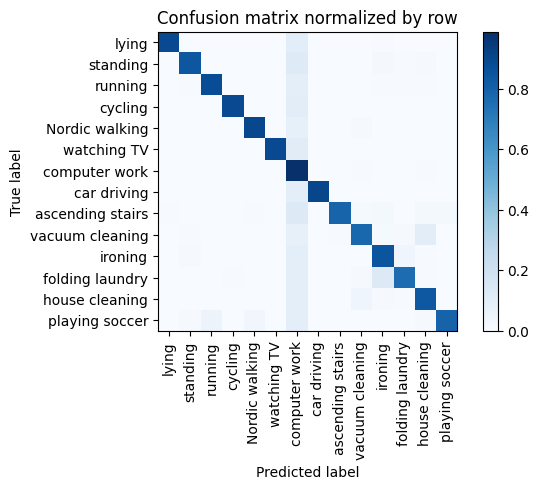

Overall accuracy: 0.868



unseen: 100%|██████████| 173/173 [00:02<00:00, 79.75batch/s, loss=7.01]


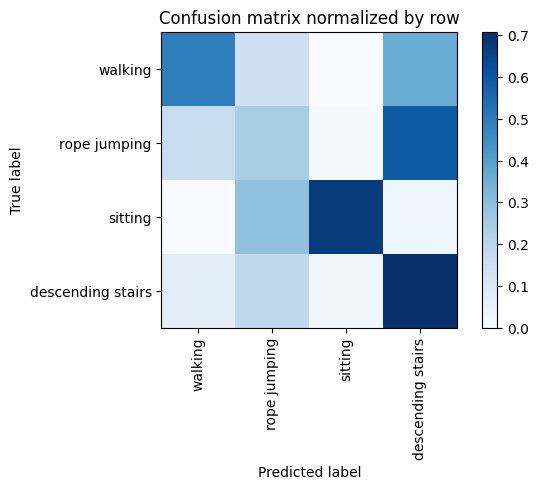

Overall accuracy: 0.569

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.888      0.492      0.633      0.421       2328|	 descending stairs: 0.357,	rope jumping: 0.149,	
          sitting       0.974      0.677      0.799      0.325       1800|	 rope jumping: 0.288,	descending stairs: 0.034,	
descending stairs       0.366      0.709      0.482      0.171        947|	 rope jumping: 0.191,	walking: 0.074,	
     rope jumping       0.097      0.243      0.138      0.083        461|	 descending stairs: 0.588,	walking: 0.163,	

----------------------------------------------------------------------------------------------------
      avg / total       0.761      0.569      0.620        1.0       5536|	      

{'total_accuracy': 0.5686416184971098, 'precision': 0.5811017586693292, 'recall': 0.530248424553191, 'f1': 0.5132661919598278}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'va

seen: 100%|██████████| 121/121 [00:02<00:00, 44.00batch/s, loss=1.11]


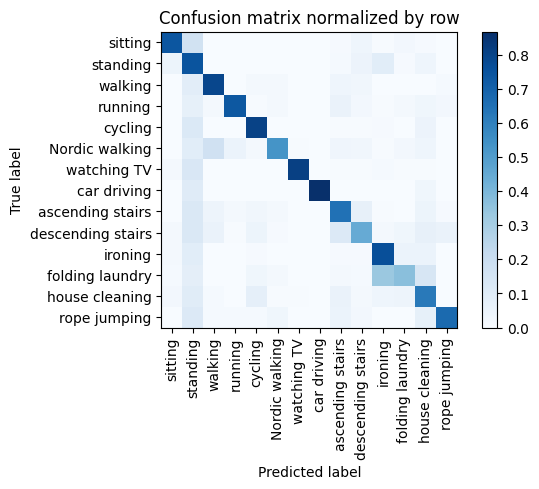

Training Epoch:  10%|█         | 1/10 [00:17<02:38, 17.63s/it]

Overall accuracy: 0.688



seen: 100%|██████████| 121/121 [00:02<00:00, 53.87batch/s, loss=0.844]


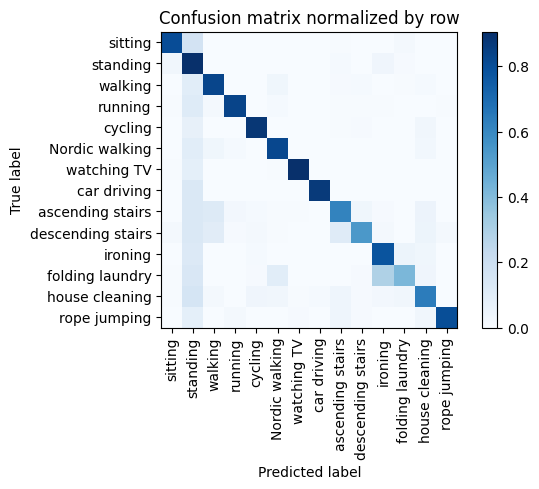

Training Epoch:  20%|██        | 2/10 [00:32<02:09, 16.14s/it]

Overall accuracy: 0.769



seen: 100%|██████████| 121/121 [00:02<00:00, 48.63batch/s, loss=0.715]


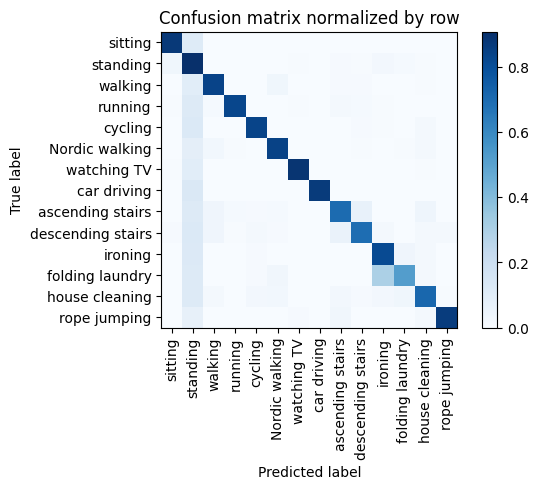

Training Epoch:  30%|███       | 3/10 [00:48<01:52, 16.07s/it]

Overall accuracy: 0.806



seen: 100%|██████████| 121/121 [00:02<00:00, 44.86batch/s, loss=0.858]


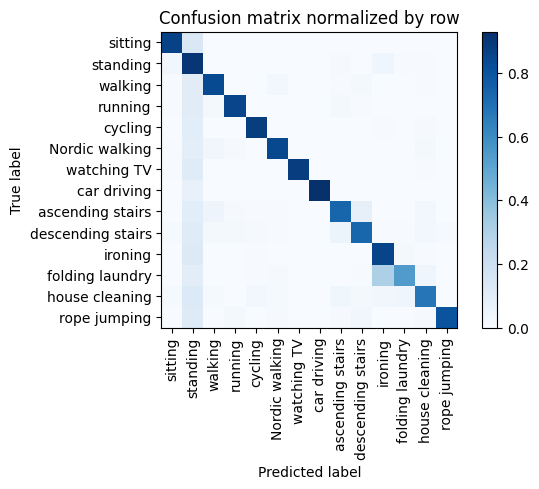

Training Epoch:  40%|████      | 4/10 [01:04<01:34, 15.82s/it]

Overall accuracy: 0.814



seen: 100%|██████████| 121/121 [00:02<00:00, 51.18batch/s, loss=0.647]


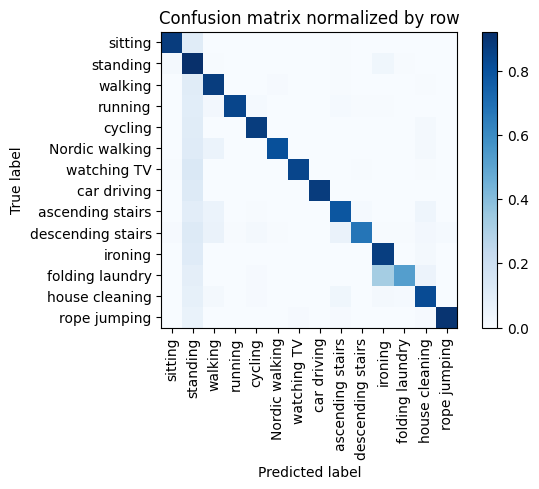

Training Epoch:  50%|█████     | 5/10 [01:19<01:17, 15.54s/it]

Overall accuracy: 0.832



seen: 100%|██████████| 121/121 [00:02<00:00, 57.29batch/s, loss=0.437]


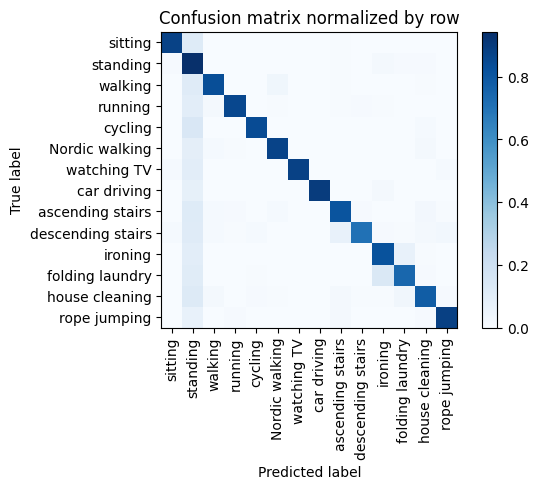

Training Epoch:  60%|██████    | 6/10 [01:33<01:00, 15.21s/it]

Overall accuracy: 0.839



seen: 100%|██████████| 121/121 [00:02<00:00, 44.11batch/s, loss=0.664]


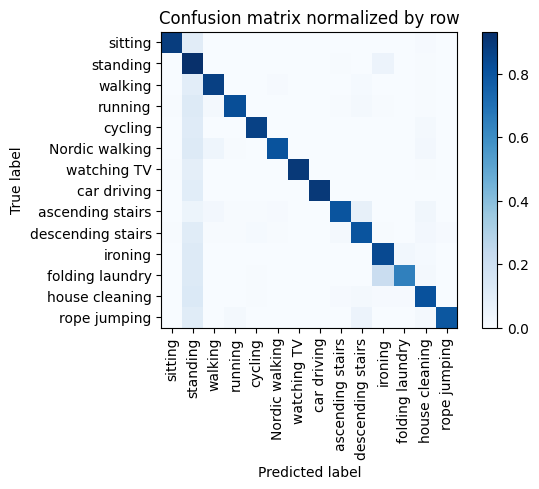

Training Epoch:  70%|███████   | 7/10 [01:50<00:47, 15.82s/it]

Overall accuracy: 0.841



seen: 100%|██████████| 121/121 [00:02<00:00, 49.11batch/s, loss=0.638]


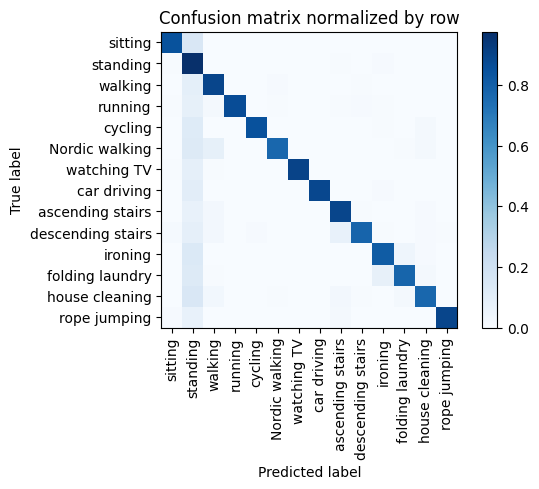

Training Epoch:  80%|████████  | 8/10 [02:05<00:31, 15.50s/it]

Overall accuracy: 0.847



seen: 100%|██████████| 121/121 [00:02<00:00, 54.24batch/s, loss=0.408]


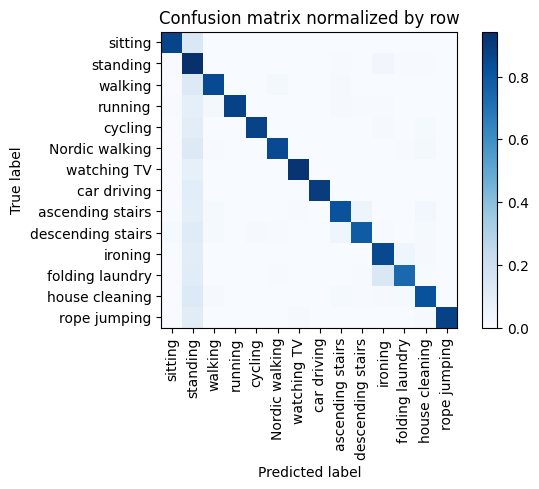

Training Epoch:  90%|█████████ | 9/10 [02:23<00:16, 16.27s/it]

Overall accuracy: 0.853



seen: 100%|██████████| 121/121 [00:02<00:00, 52.54batch/s, loss=0.406]


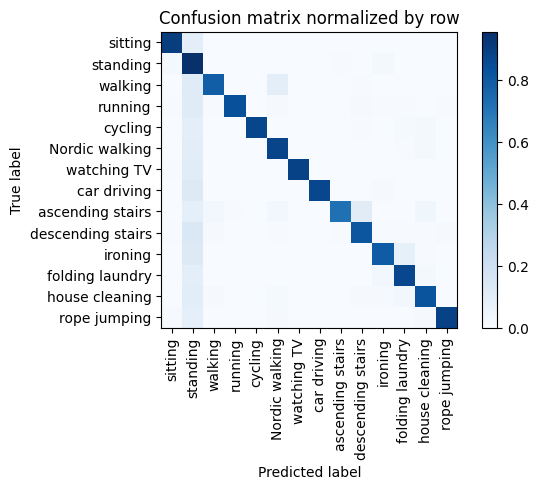

Overall accuracy: 0.846



unseen: 100%|██████████| 222/222 [00:02<00:00, 74.35batch/s, loss=12.3]


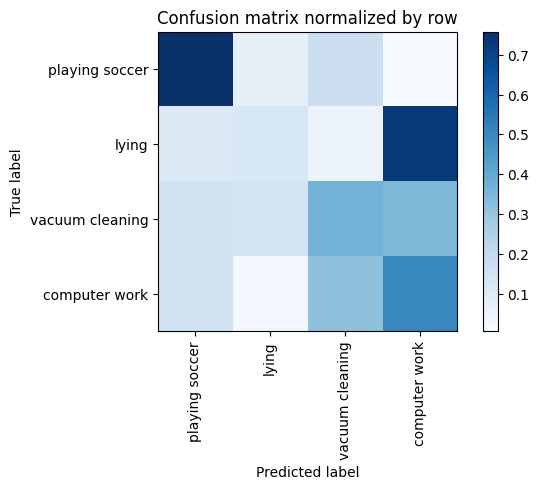

Overall accuracy: 0.386

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.441      0.504      0.471      0.432       3067|	 vacuum cleaning: 0.316,	playing soccer: 0.154,	
          lying       0.399      0.121      0.186      0.264       1873|	 computer work: 0.727,	playing soccer: 0.101,	
vacuum cleaning       0.353      0.365      0.359      0.240       1706|	 computer work: 0.349,	playing soccer: 0.149,	
 playing soccer       0.274      0.758      0.403      0.064        458|	 vacuum cleaning: 0.170,	lying: 0.066,	

----------------------------------------------------------------------------------------------------
    avg / total       0.398      0.386      0.364        1.0       7104|	      

{'total_accuracy': 0.3861204954954955, 'precision': 0.36681344565228907, 'recall': 0.4369587760846442, 'f1': 0.3544943889825091}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking'

seen: 100%|██████████| 138/138 [00:04<00:00, 29.06batch/s, loss=1.35]


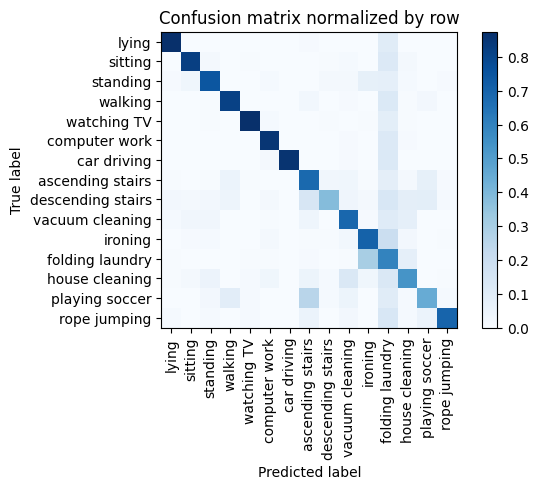

Training Epoch:  10%|█         | 1/10 [00:22<03:23, 22.65s/it]

Overall accuracy: 0.733



seen: 100%|██████████| 138/138 [00:03<00:00, 38.64batch/s, loss=0.7]


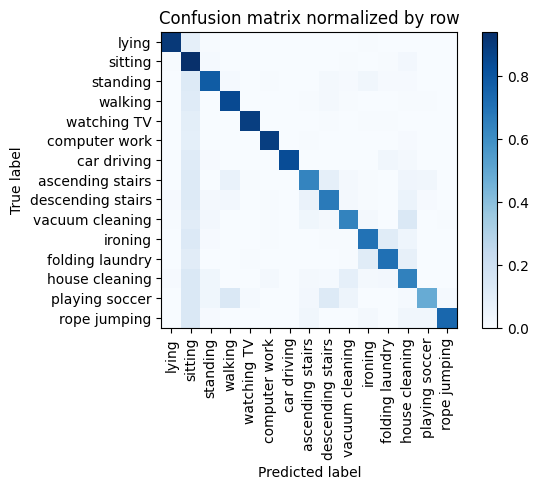

Training Epoch:  20%|██        | 2/10 [00:50<03:24, 25.59s/it]

Overall accuracy: 0.778



seen: 100%|██████████| 138/138 [00:02<00:00, 53.63batch/s, loss=0.648]


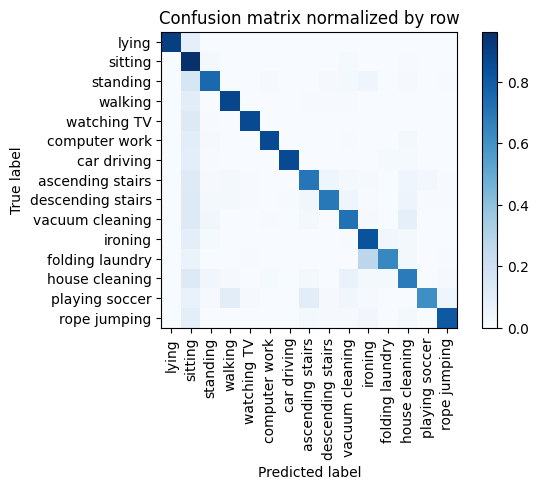

Training Epoch:  30%|███       | 3/10 [01:08<02:34, 22.04s/it]

Overall accuracy: 0.808



seen: 100%|██████████| 138/138 [00:03<00:00, 39.84batch/s, loss=0.473]


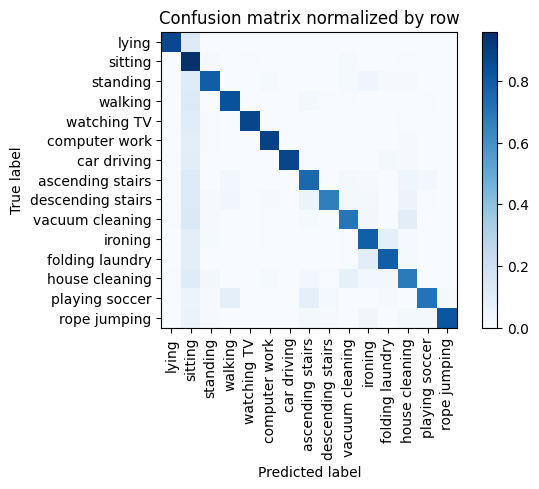

Training Epoch:  40%|████      | 4/10 [01:24<01:58, 19.74s/it]

Overall accuracy: 0.811



seen: 100%|██████████| 138/138 [00:03<00:00, 43.23batch/s, loss=0.651]


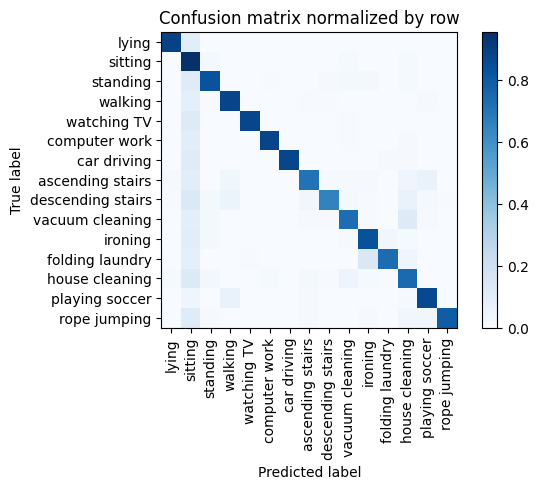

Training Epoch:  50%|█████     | 5/10 [01:45<01:41, 20.23s/it]

Overall accuracy: 0.828



seen: 100%|██████████| 138/138 [00:02<00:00, 53.75batch/s, loss=0.379]


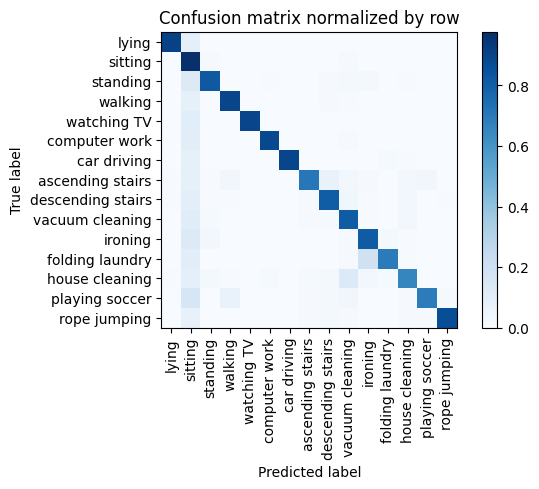

Training Epoch:  60%|██████    | 6/10 [02:02<01:16, 19.19s/it]

Overall accuracy: 0.833



seen: 100%|██████████| 138/138 [00:02<00:00, 63.48batch/s, loss=0.482]


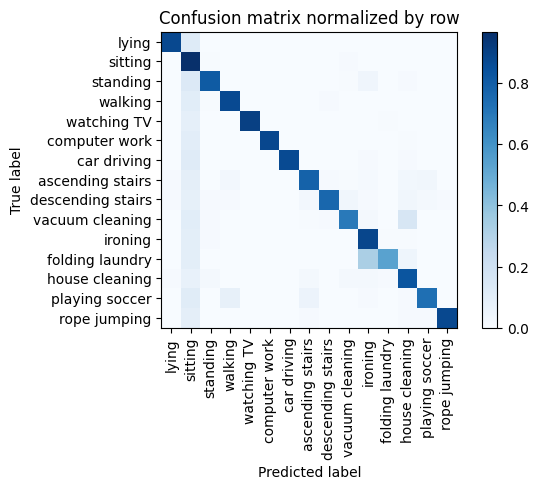

Training Epoch:  70%|███████   | 7/10 [02:18<00:54, 18.16s/it]

Overall accuracy: 0.835



seen: 100%|██████████| 138/138 [00:03<00:00, 44.32batch/s, loss=0.247]


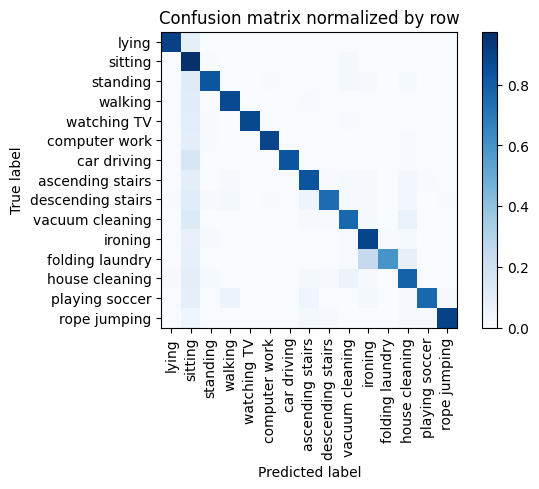

Training Epoch:  80%|████████  | 8/10 [02:36<00:36, 18.11s/it]

Overall accuracy: 0.849



seen: 100%|██████████| 138/138 [00:02<00:00, 50.77batch/s, loss=0.336]


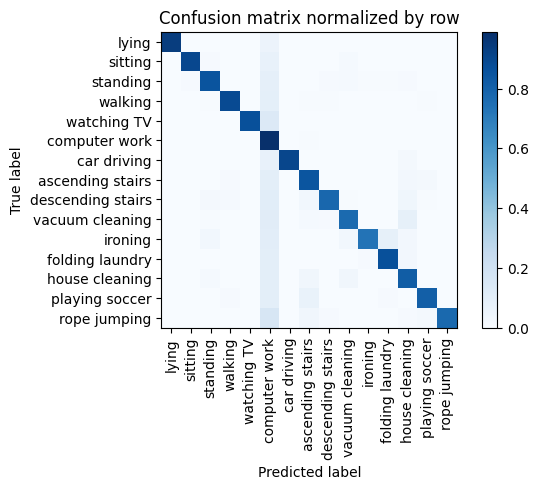

Training Epoch:  90%|█████████ | 9/10 [02:54<00:18, 18.18s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 138/138 [00:02<00:00, 54.10batch/s, loss=0.361]


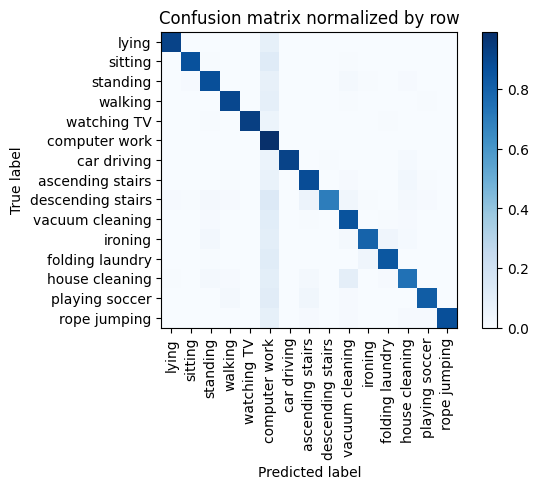

Overall accuracy: 0.870



unseen: 100%|██████████| 137/137 [00:01<00:00, 85.41batch/s, loss=11.8]


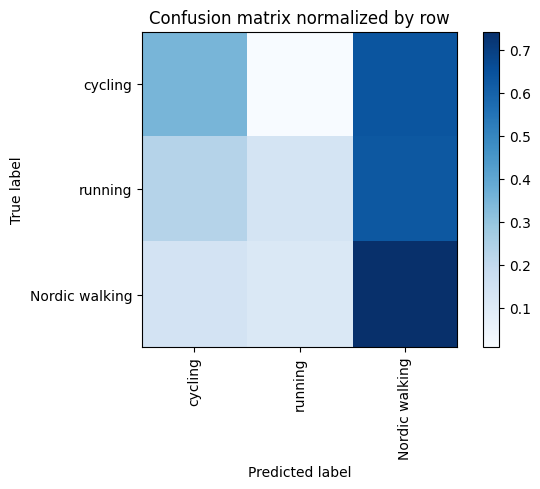

Overall accuracy: 0.470

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.458      0.743      0.566      0.419       1837|	 cycling: 0.143,	running: 0.114,	
       cycling       0.539      0.351      0.425      0.365       1602|	 Nordic walking: 0.639,	running: 0.010,	
       running       0.370      0.141      0.204      0.216        945|	 Nordic walking: 0.629,	cycling: 0.231,	

----------------------------------------------------------------------------------------------------
   avg / total       0.469      0.470      0.437        1.0       4384|	      

{'total_accuracy': 0.4698905109489051, 'precision': 0.4558046578625012, 'recall': 0.41153718741913137, 'f1': 0.398497078667644}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


seen: 100%|██████████| 141/141 [00:02<00:00, 47.09batch/s, loss=1.18]


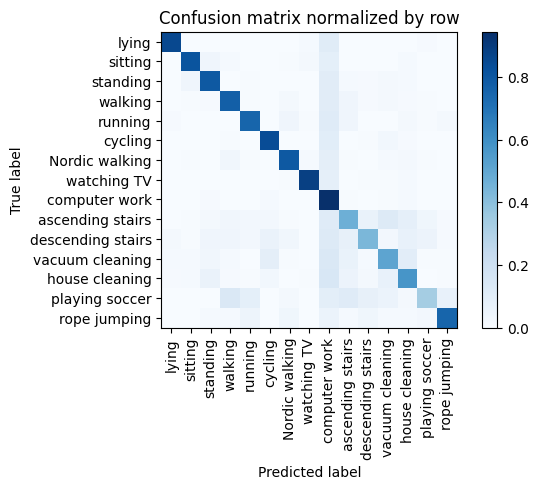

Training Epoch:  10%|█         | 1/10 [00:20<03:04, 20.55s/it]

Overall accuracy: 0.742



seen: 100%|██████████| 141/141 [00:02<00:00, 50.18batch/s, loss=0.951]


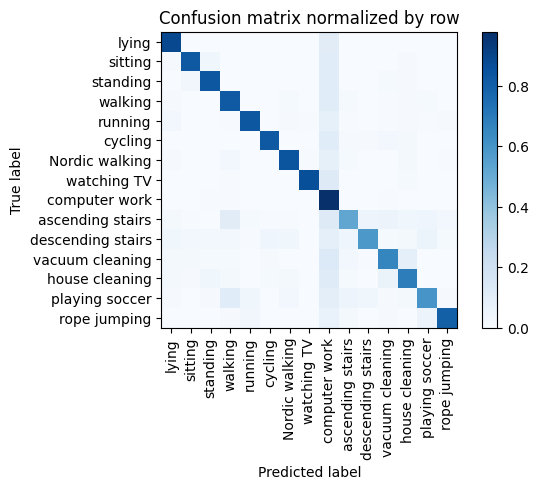

Training Epoch:  20%|██        | 2/10 [00:38<02:33, 19.24s/it]

Overall accuracy: 0.797



seen: 100%|██████████| 141/141 [00:02<00:00, 56.15batch/s, loss=0.605]


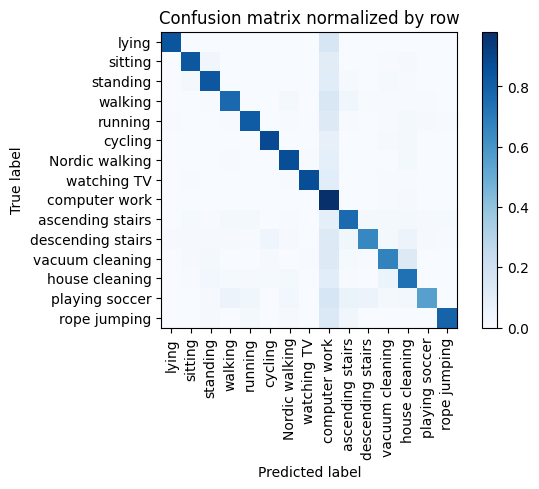

Training Epoch:  30%|███       | 3/10 [00:56<02:11, 18.72s/it]

Overall accuracy: 0.815



seen: 100%|██████████| 141/141 [00:02<00:00, 63.86batch/s, loss=0.498]


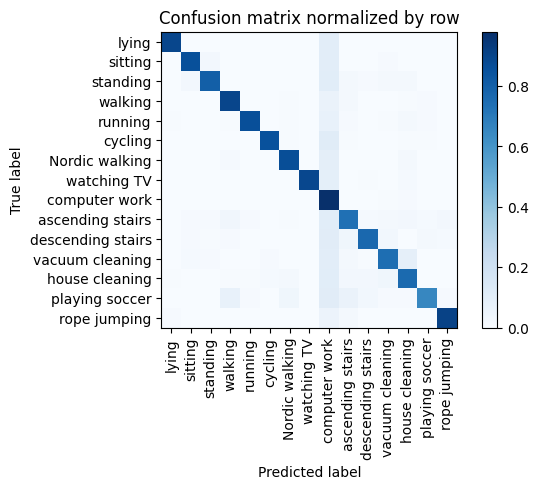

Training Epoch:  40%|████      | 4/10 [01:15<01:50, 18.46s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 141/141 [00:02<00:00, 47.47batch/s, loss=0.46]


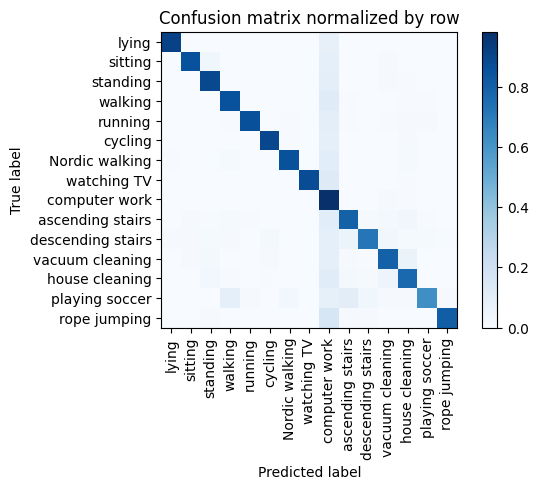

Training Epoch:  50%|█████     | 5/10 [01:33<01:33, 18.63s/it]

Overall accuracy: 0.857



seen: 100%|██████████| 141/141 [00:02<00:00, 50.20batch/s, loss=0.469]


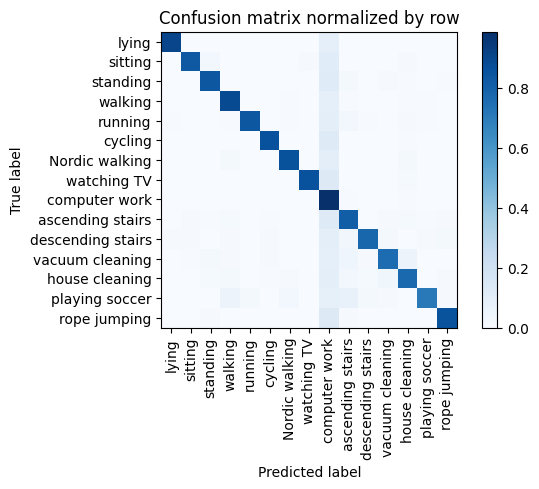

Training Epoch:  60%|██████    | 6/10 [01:54<01:17, 19.36s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 141/141 [00:02<00:00, 57.40batch/s, loss=0.621]


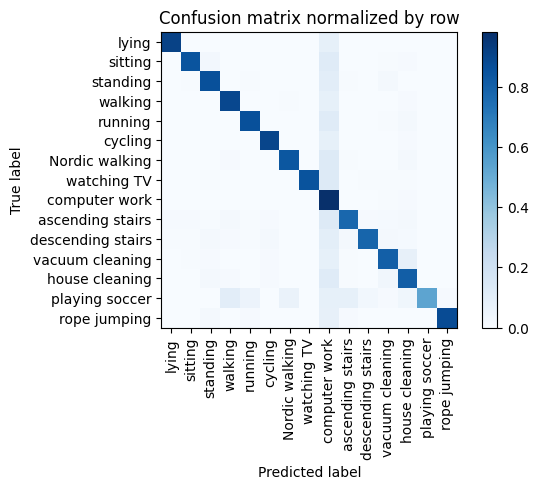

Training Epoch:  70%|███████   | 7/10 [02:12<00:56, 18.96s/it]

Overall accuracy: 0.859



seen: 100%|██████████| 141/141 [00:02<00:00, 57.06batch/s, loss=0.3]


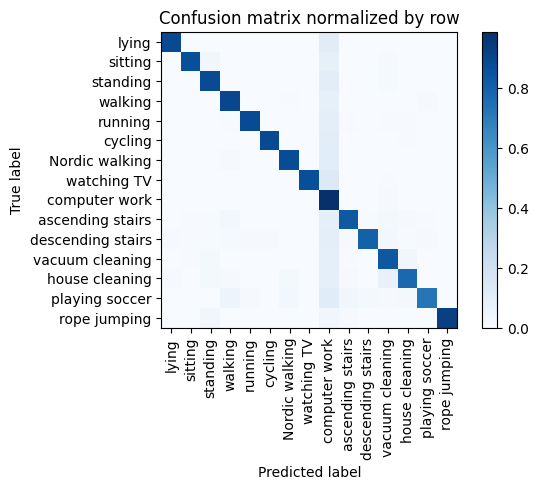

Training Epoch:  80%|████████  | 8/10 [02:29<00:36, 18.10s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 141/141 [00:04<00:00, 34.19batch/s, loss=0.511]


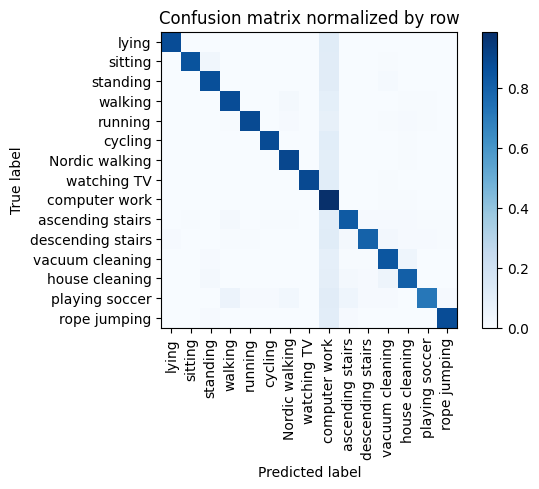

Training Epoch:  90%|█████████ | 9/10 [02:49<00:18, 18.67s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 141/141 [00:03<00:00, 42.95batch/s, loss=0.475]


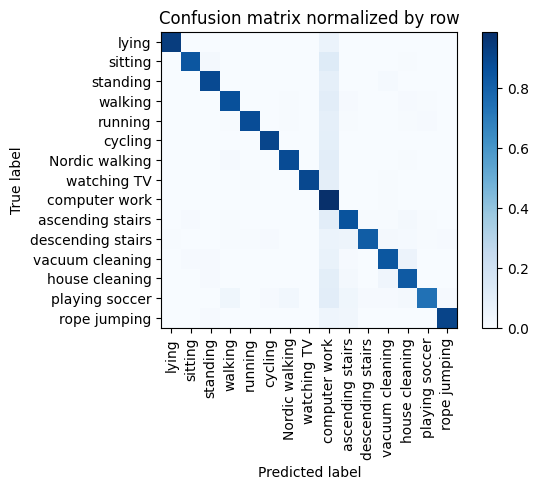

Overall accuracy: 0.883



unseen: 100%|██████████| 120/120 [00:01<00:00, 72.31batch/s, loss=8.22]


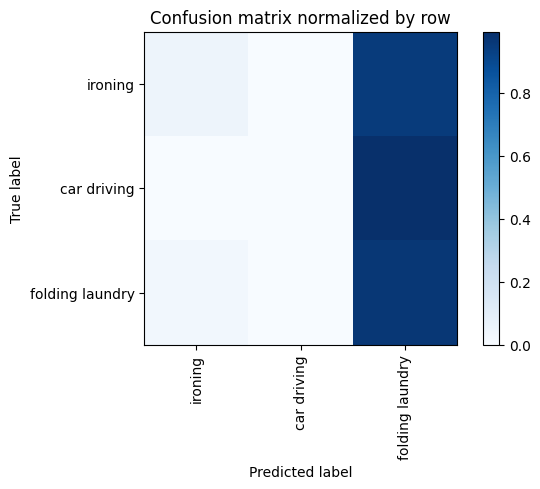

Overall accuracy: 0.274

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.783      0.048      0.090      0.608       2333|	 folding laundry: 0.950,	car driving: 0.002,	
folding laundry       0.255      0.968      0.404      0.253        972|	 ironing: 0.030,	car driving: 0.002,	
    car driving       0.000      0.000      0.000      0.139        535|	 folding laundry: 0.996,	ironing: 0.004,	

----------------------------------------------------------------------------------------------------
    avg / total       0.540      0.274      0.157        1.0       3840|	      

{'total_accuracy': 0.27421875, 'precision': 0.3460767777840949, 'recall': 0.3387046180024542, 'f1': 0.16471930042204677}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.421846
precision         0.446803
recall            0.429642
f1                0.365362
dtype: float64

In [15]:
# create model weights & weight changing record folder 
today = datetime.now()
h = "00" if (today.hour < 12) else "12"
tmp_dir = "./tmp/model_006b_weight/" + today.strftime('%Y-%m-%d_%H-%M')+ h
os.mkdir(tmp_dir)

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    if dt == 'UTD':
        train_n = len(data_dict['train']['X'])
        seq_len, in_ft = 100, 6
    else:
        train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = dts(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = dts(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len, n_classes=len(seen_classes))
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    prev_list, rmae_delta_dict = setup_delta_tracking(model)
    
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics, rmae_delta_dict, prev_list = train_step1(train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], prev_list=prev_list, rmae_delta_dict=rmae_delta_dict, phase='train', loss_alpha=0.8)
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen', print_report=False, loss_alpha=0.8)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())

    # model layer change recording 
    np.save(f"{tmp_dir}/Fold{i}_rmae_dict.npy", rmae_delta_dict)
        
    if best_acc < eval_metrics['total_accuracy']:
        best_model = deepcopy(model.state_dict())
    
    # save the best model 
    torch.save(best_model, f'./tmp/model_006b_weight/Fold{i}_model_weights.pt')

    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen', loss_alpha=0.8)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    